# Sensitivity analysis </a><a name='top'>

In this notebook we try to study the sensivity of our model to critical parameters.

[Define general default parameters for the whole of the analysis](#default)

[Define the 5 fields that change for each parameter tested](#testing)
    
    
**WARNING: FOR SECURITY OF DATA, SET save_figures TO FALSE AFTER EACH USE AND CHANGE NAME OF directory_to_save_figs_in (OTHERWISE FIGURES THAT WERE PREVIOUSLY SAVED MIGHT BE LOST BY REPLACEMENT).**

In [2]:
# TODO: TODOs hehe, correct model
# TODO should the tests be carried out on several geographical points?

## Imports and functions

In [11]:
%run little_awk_functions.py
%run parameters.py

## Define default parameters </a><a name='default'>

These should be defined once only at the beginning of the analysis, and not changed during the process.

In [2]:
paramdic = {}

In [44]:
# Dataset

name_of_data_set = 'snow_pit_1_filled.nc'

save_figures = False
save_text_results = False

directory_to_save_figs_in = '/home/mabonnet/github/MB_little_awk/current_development/Sensitivity_tests_figs_2/'

paramdic['data_set_used'] = name_of_data_set

In [4]:
# Events detection parameters

x_sel = 10
y_sel = 10
time_window_std = 25     # TODO real value
std_threshold = 0.015    # TODO choose the correct threshold here

paramdic['x_sel'] = x_sel
paramdic['y_sel'] = y_sel
paramdic['time_window_std'] = time_window_std
paramdic['std_threshold'] = std_threshold

In [12]:
# Compaction/temperature model parameters

tsfc = -5
dt = 100
a1 = 0.0013     # TODO
a2 = 0.021      # TODO

use_true_temp = True   # set to True if want to use the correct temperature forcing

simul_new_snow_ro = 150         # TODO choose the correct value here

paramdic['tsfc'] = tsfc
paramdic['dt'] = dt
paramdic['a1'] = a1
paramdic['a2'] = a2
paramdic['use_true_temp'] = use_true_temp
paramdic['simul_new_snow_ro'] = simul_new_snow_ro

# Will not be varied for now

simul_fit_top_of_snowfall_to_curve = False
tf = 0
ro_water = 1000
ro_ice = 910
cp_snow = 2106
jj = 0

paramdic['stable_parameters'] = 'max nb layers ' + str(max_nb_of_layers) + '; do not fit top of snowfall to curve; tf 0; ro water 1000; ro ice 910; cp snow 2106; initial nb layers 0'

In [6]:
# Save default parameters in a .txt file

if save_text_results:
    with open(directory_to_save_figs_in + 'sensitivity_tests.txt', 'a') as param_file:
        param_file.write(str(paramdic) + '\n \n')

[Back to top section](#top)

## Clean dataset and derive other parameters

You should only need to run this once.

In [7]:
# Pre-processing to get clean data

data_set_used = xr.open_dataset(name_of_data_set)

if name_of_data_set == 'data_2021-2022.nc':
    fill_in_missing_variables(data_set_used, 'surface')

data_set_used = data_set_used.ffill(dim='time')

median_space_filtering(data_set_used, 5, x_span=7)
median_time_filtering(data_set_used, 11)

data_set_used['snow_surface'] = data_set_used['snow_surface'] - data_set_used['snow_surface'].isel(x=x_sel, y=y_sel).dropna('time').min()


---> Median filtering in space with a window [7, 11]
---> Median filtering in time with a window of 11


In [15]:
# Define dates

data_starting_date_in_ns = float(data_set_used.time.values[0])

data_starting_date_in_s = pd.to_datetime(data_set_used.time.values[0]).timestamp()
data_ending_date_in_s = pd.to_datetime(data_set_used.time.values[-1]).timestamp()
data_duration_in_s = data_ending_date_in_s - data_starting_date_in_s
nb_iterations = int(data_duration_in_s/dt + 1)

data_start_date = pd.to_datetime(data_set_used.time.values[0])

nb_iterations = int(data_duration_in_s/dt + 1)

In [13]:
# Meteorological forcing

if use_true_temp:
    met_time, met_temp = get_met_forcing()
else:
    met_time, met_temp = [0], [tsfc]

In [14]:
# Create comparable data between lidar and simulation (same timestamps)

lidar_height_array = []
keep_simul_times_indices = []    # indices of the timestamps to keep in the simulation data, that are comparable to the lidar data
                                # given that dt << lidar scans time period, there are no repetitions in keep_simul_times_indices
ignore = np.isnan(data_set_used.snow_surface.isel(x=x_sel, y=y_sel))     # do not take into account the nan values in the dataset

for index in range(len(data_set_used.time.values)):
        lidar_time_in_s = float(data_set_used.time.values[index]) / 1000000000 - float(data_set_used.time.values[0]) / 1000000000
        if lidar_time_in_s < nb_iterations*dt and not ignore[index]:
            lidar_height_array.append(data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=index))

            index_of_closest_time_in_simul = int(lidar_time_in_s//dt + round((lidar_time_in_s%dt)/dt))
            keep_simul_times_indices.append(index_of_closest_time_in_simul)

lidar_height_array = np.array(lidar_height_array)

## Loop on parameter of interest variation </a><a name='testing'>

There are 5 fields to change each time (see TODOs).

In [40]:
# Define all the values the parameter of interest will take

# name_of_param = 'time_window_std'   # TODO update this each time

default_value_of_tw = 25
range_of_tw_variation = [13, 25, 37]

default_value_of_st = 0.015
range_of_st_variation = [0.0001, 0.01, 0.015, 0.02, 0.03]

result_list_rmse = []            # TODO adapt to chosen metric
result_list_stde = []
result_list_pcorr = []

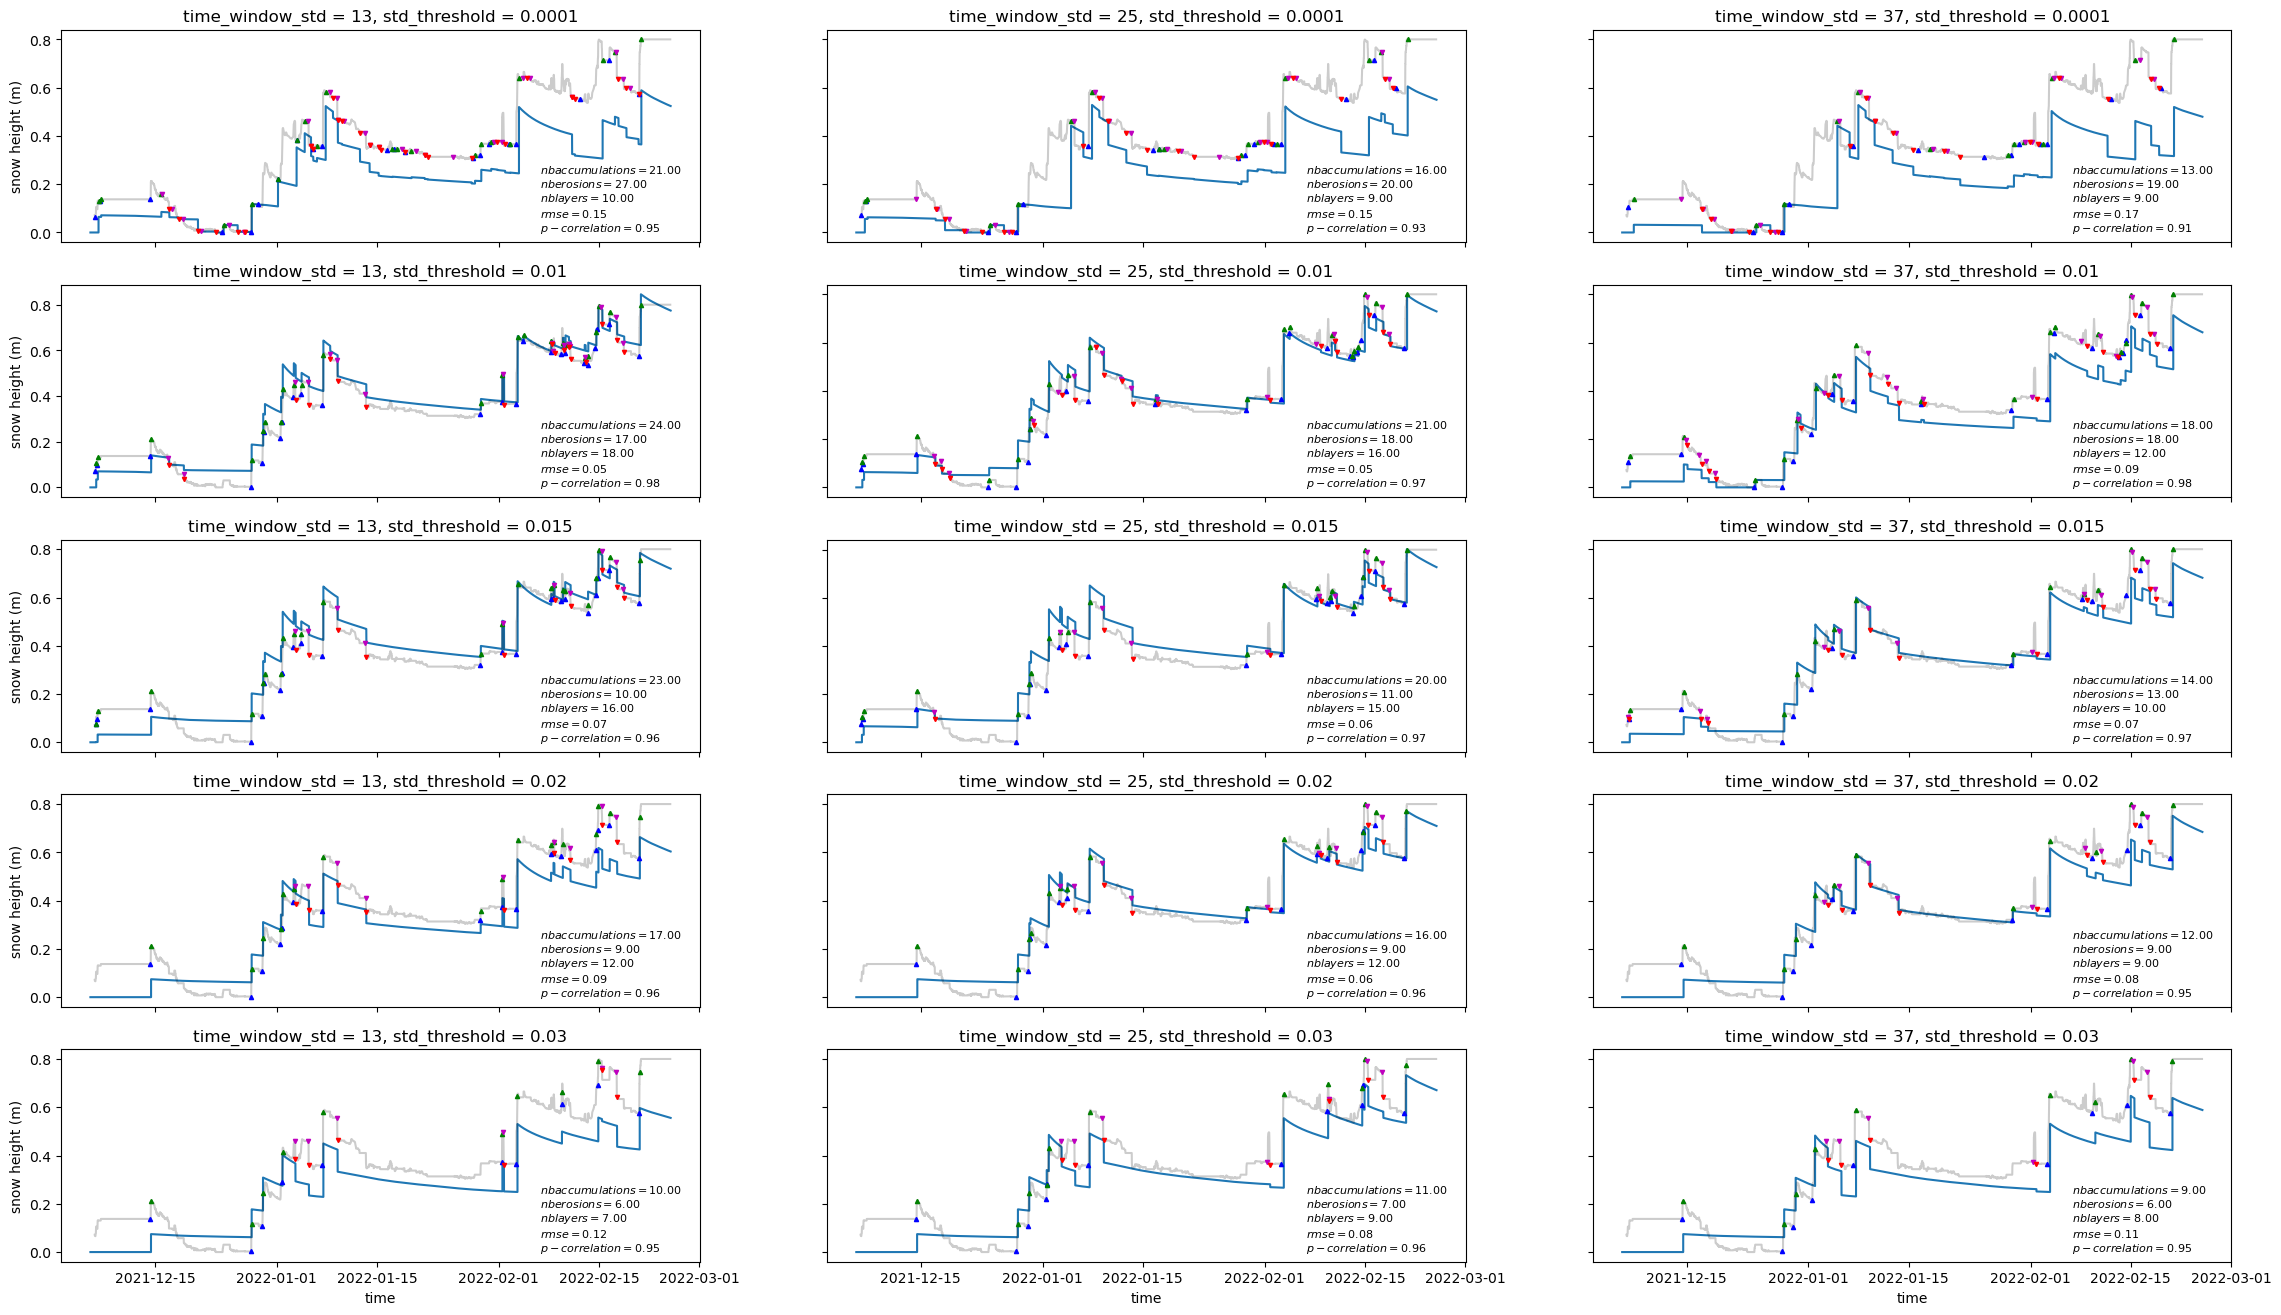

In [41]:
fig, axs = plt.subplots(5, 3, figsize=(28, 16))

for ax in axs.flat:
    ax.set(xlabel='time', ylabel='snow height (m)')
    ax.label_outer()

for tw_index in range(len(range_of_tw_variation)):
    
    for st_index in range(len(range_of_st_variation)):
    
        time_window_std = range_of_tw_variation[tw_index]
        std_threshold = range_of_st_variation[st_index]
    
    
        results = get_snow_events(data_set_used, x_sel, y_sel, time_window_std, std_threshold)
        start_accumulation, start_erosion, end_accumulation, end_erosion = results[0], results[1], results[2], results[3]

        # Convert end times into more manageable orders of magnitude

        end_accumulation_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=end_accumulation)
        end_accumulation_times = (pd.to_datetime(end_accumulation_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s

        end_erosion_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=end_erosion)
        end_erosion_times = (pd.to_datetime(end_erosion_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s

        # Update variables at each timepoint

        snowpack = simulate_snowpack_evolution(data_set_used, x_sel, y_sel, nb_iterations, end_accumulation_times, end_erosion_times,
                                       start_accumulation, end_accumulation, start_erosion, end_erosion, jj, dt, ro_layer, ro_water, ro_ice,
                                       t_old, tf, tsfc, dy_snow, age_layers, gamma, cp_snow, melt_flag, a1, a2, met_temp_data=met_temp,
                                       met_time_data=met_time, new_snow_ro=simul_new_snow_ro, fit_top_of_snowfall_to_curve=simul_fit_top_of_snowfall_to_curve)

        ro_layer_evolution, depth_evolution, temperature_evolution = snowpack[0], snowpack[1], snowpack[2]
     
        # Define total_snow_depth
    
        simulation_times = pd.date_range(start=data_start_date,freq=str(dt)+'S',periods=nb_iterations)
        total_snow_depth = np.array([sum(depth_evolution[i][j] for j in range(max_nb_of_layers)) for i in range(len(depth_evolution))])
        total_snow_depth_comparable = np.array([sum(depth_evolution[i][j] for j in range(max_nb_of_layers)) for i in range(len(depth_evolution)) if i in keep_simul_times_indices])
        
        nb_layers_detected = len([i for i in depth_evolution[-1] if i != 0])
    
        # Plot results to compare
            
        axs[st_index, tw_index].plot(simulation_times, total_snow_depth, label='simulated snow depth')
        axs[st_index, tw_index].set_title('time_window_std = '+str(range_of_tw_variation[tw_index]) + ', std_threshold = '+str(range_of_st_variation[st_index]))
    
        axs[st_index, tw_index].plot(data_set_used.time.values, data_set_used.isel(x=x_sel, y=y_sel).snow_surface, c='k', alpha=0.2)

        axs[st_index, tw_index].plot(data_set_used.time.values[start_accumulation], data_set_used.isel(x=x_sel, y=y_sel, time=start_accumulation).snow_surface, c='b', marker='^', markersize=3, linestyle='None', label='start accum.')
        axs[st_index, tw_index].plot(data_set_used.time.values[end_accumulation], data_set_used.isel(x=x_sel, y=y_sel, time=end_accumulation).snow_surface, c='g', marker='^', markersize=3, linestyle='None', label='end accum.')
        axs[st_index, tw_index].plot(data_set_used.time.values[start_erosion], data_set_used.isel(x=x_sel, y=y_sel, time=start_erosion).snow_surface, c='m', marker='v', markersize=3, linestyle='None', label='start erosion')
        axs[st_index, tw_index].plot(data_set_used.time.values[end_erosion], data_set_used.isel(x=x_sel, y=y_sel, time=end_erosion).snow_surface, c='r', marker='v', markersize=3, linestyle='None', label='end erosion')

        # Evaluate similarity between simulated and measured curves
    
        result_eval_rmse = rmse_measure(total_snow_depth_comparable, lidar_height_array)    # TODO adapt to chosen metrics
        result_eval_stde = stderr_measure(total_snow_depth_comparable, lidar_height_array)
        result_eval_pcorr = p_correl_measure(total_snow_depth_comparable, lidar_height_array)
    
        # result_list_rmse.append(result_eval_rmse)    # TODO adapt to chosen metrics
        # result_list_stde.append(result_eval_stde)
        # result_list_pcorr.append(result_eval_pcorr)
        
        # Add text box with extra info
        
        textstr = '\n'.join((r'$nb accumulations=%.2f$' % (len(start_accumulation), ), r'$nb erosions=%.2f$' % (len(start_erosion), ), r'$nb layers=%.2f$' % (nb_layers_detected, ),
                             r'$rmse=%.2f$' % (result_eval_rmse, ), r'$p-correlation=%.2f$' % (result_eval_pcorr, )))
        axs[st_index, tw_index].text(0.75, 0.2, textstr, horizontalalignment='left', verticalalignment='center', transform=axs[st_index, tw_index].transAxes, fontsize=8)

[Back to top section](#top)

In [43]:
if save_figures:
    fig.savefig(directory_to_save_figs_in + 'graph_st_tw.png')

In [21]:
# Save parameters and results in a .txt file

if save_text_results:
    with open(directory_to_save_figs_in + 'sensitivity_tests.txt', 'a') as param_file:
        param_file.write(name_of_param + str(range_of_param_variation) + ' results for rmse: ' + str(result_list_rmse) + ' results for standard error: ' + str(result_list_stde) + ' results for p-correlation: ' + str(result_list_pcorr) + '\n \n')
    # TODO adapt to chosen metrics

## Plot results in terms of different metrics

In [22]:
# TODO adapt all that follows to chosen metrics

NameError: name 'range_of_param_variation' is not defined

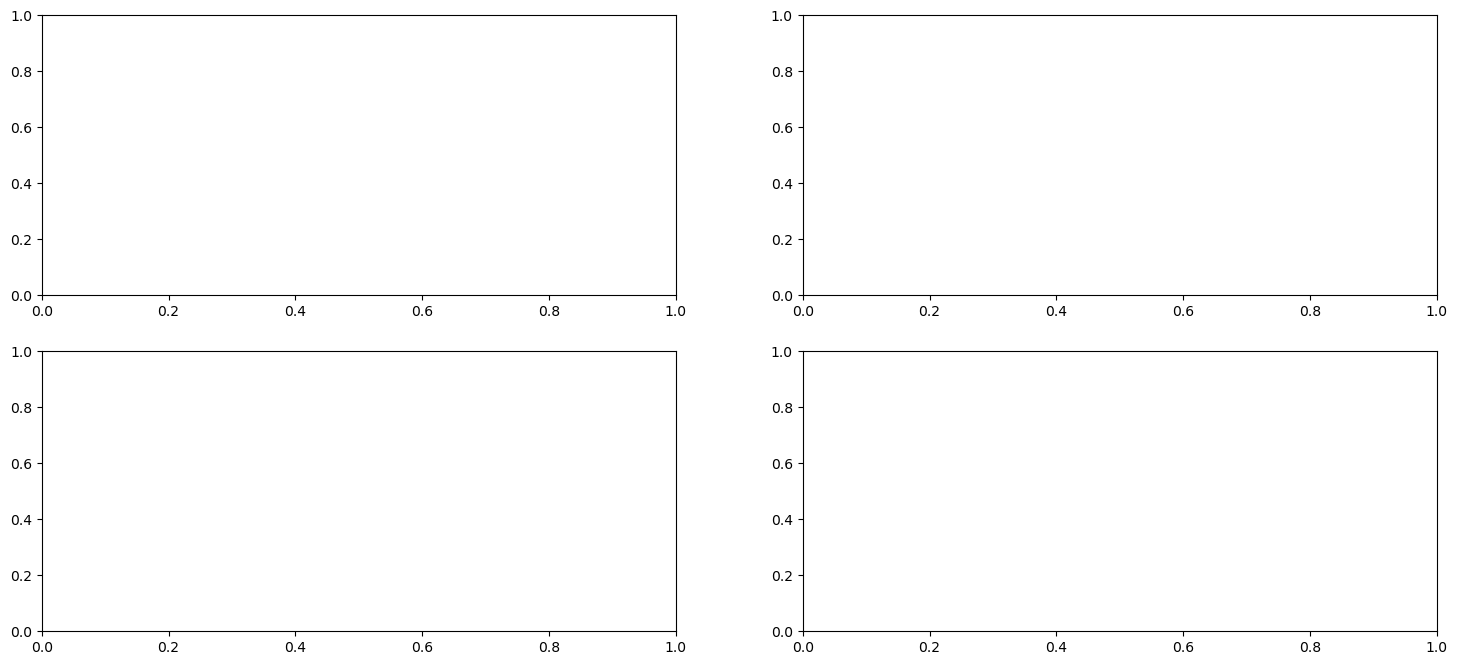

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(18, 8))
axs[0, 0].plot(range_of_param_variation, result_list_rmse, marker='v')
axs[0, 0].set_title('Root mean square error - ' + name_of_param)

axs[0, 1].plot(range_of_param_variation, result_list_stde, marker='v')
axs[0, 1].set_title('Standard error - ' + name_of_param)

axs[1, 0].plot(range_of_param_variation, result_list_pcorr, marker='v')
axs[1, 0].set_title('Pearson correlation - ' + name_of_param)

axs[1, 1].plot(range_of_param_variation, result_list_pcorr, linestyle='None')

for ax in axs.flat:
    ax.set(xlabel='parameter value', ylabel='difference to lidar curve')
    
# TODO add a colored marker for the default value?


In [22]:
if save_figures:
    fig.savefig(directory_to_save_figs_in + 'results_'+name_of_param+'.png')

## Transpose results into percentages for comparatibility

In [23]:
def list_to_percent(param_list, default_value):
    '''
    Function that converts values in a list to the percentage of a default value they represent
    Args:
        param_list: list of values to be converted
        default_value: value that corresponds to 100%
    Returns:
        percent_param_list: array containing the converted values
    '''
    param_list = np.array(param_list)
    percent_param_list = np.divide(param_list, default_value) * 100
    return(percent_param_list)

In [24]:
index_of_default = range_of_param_variation.index(default_value_of_param)

percent_params = list_to_percent(range_of_param_variation, default_value_of_param)
percent_results_rmse = list_to_percent(result_list_rmse, result_list_rmse[index_of_default])
percent_results_stde = list_to_percent(result_list_stde, result_list_stde[index_of_default])
percent_results_pcorr = list_to_percent(result_list_pcorr, result_list_pcorr[index_of_default])

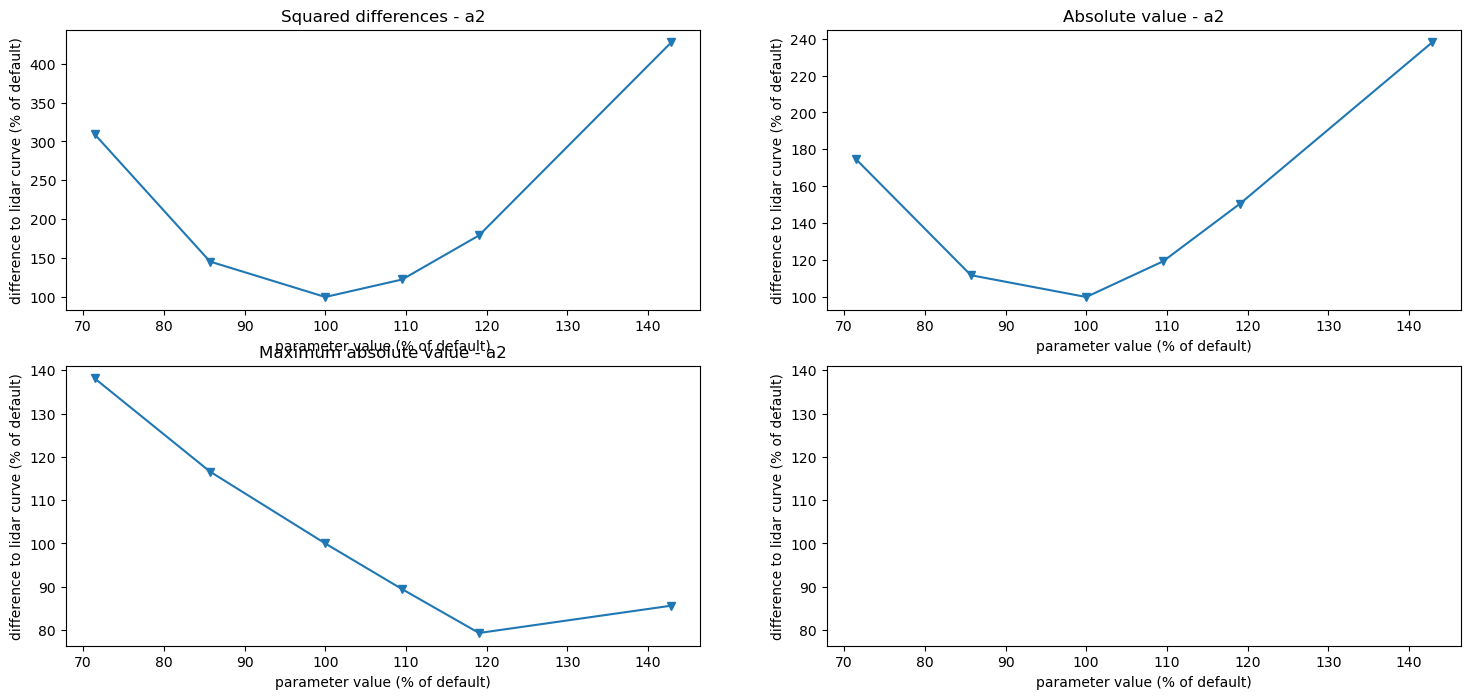

In [25]:
#from matplotlib import rc    # TODO
#rc('text', usetex=True)
# rc('font', size=14)
# rc('legend', fontsize=13)
#rc('text.latex', preamble=r'\usepackage{cmbright}')

#import matplotlib
#matplotlib.rcParams['text.usetex'] = True

fig, axs = plt.subplots(2, 2, figsize=(18, 8))
axs[0, 0].plot(percent_params, percent_results_rmse, marker='v')
axs[0, 0].set_title('Root mean square error - ' + name_of_param)

axs[0, 1].plot(percent_params, percent_results_stde, marker='v')
axs[0, 1].set_title('Standard error - ' + name_of_param)

axs[1, 0].plot(percent_params, percent_results_pcorr, marker='v')
axs[1, 0].set_title('Pearson correlation - ' + name_of_param)

axs[1, 1].plot(percent_params, percent_results_pcorr, linestyle='None')

for ax in axs.flat:
    ax.set(xlabel='parameter value (% of default)', ylabel='difference to lidar curve (% of default)')


In [26]:
if save_figures:
    fig.savefig(directory_to_save_figs_in + 'results_percent_'+name_of_param+'.png')

In [27]:
grad_sq = np.gradient(percent_results_rmse, percent_params)
grad_abs = np.gradient(percent_results_stde, percent_params)
grad_max_abs = np.gradient(percent_results_pcorr, percent_params)

In [28]:
# Save percentages and gradients in a .txt file

if save_text_results:
    with open(directory_to_save_figs_in + 'sensitivity_tests.txt', 'a') as param_file:
        param_file.write(name_of_param + ' ALL VALUES IN % OF DEFAULT: ' + str(percent_params) + ' results for rmse: ' + str(percent_results_rmse) + ' results for standard error: ' + str(percent_results_stde) + ' results for p-correlation: ' + str(percent_results_pcorr) + '\n')
        param_file.write(name_of_param + ' gradients of results at each point (partial derivative with respect to parameter, computed on the % curves): ' + ' for rmse: ' + str(grad_sq) + ' for standard error: ' + str(grad_abs) + ' for p-correlation: ' + str(grad_max_abs) + '\n \n')


[Back to top section](#top)